# RDECDARW: ResNet-based Deep Embedded Clustering with Data Augmentation and Representation Weighting 

In [ ]:
from google.colab import drive
drive.mount('/content/clustering')

In [ ]:
import numpy as np
np.random.seed(10)

In [ ]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, accuracy_score, homogeneity_score

nmi_fun = normalized_mutual_info_score
ari_fun = adjusted_rand_score
# acc_fun = homogeneity_score

def acc_fun (y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind = list(linear_assignment(w.max() - w))
    acc_sum = 0
    for k in range(len(w)):
       acc_sum =  w[ind[0][k],ind[1][k]] + acc_sum
    return acc_sum * 1.0 / y_pred.size

In [ ]:
from time import time
import keras.backend as K
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input, Reshape
from keras.models import Model
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans, MiniBatchKMeans,k_means
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

In [ ]:
# mnist test Dataset
from keras.datasets import mnist

(x_train, y_train), (x, y) = mnist.load_data()

x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)
n_clusters = 10
img_size = (28, 28)
update_interval = 140
batch_size = 256

In [ ]:
from tensorflow.keras import layers
import keras.backend as K

def get_model(dims, act='relu', init='glorot_uniform'):
    n_stacks = len(dims) - 1
    # input
    inputs = layers.Input(shape=(dims[0],))
    x = inputs

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Dense(dims[1], activation=act, kernel_initializer=init)(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for i in range(n_stacks-2):
        x = layers.Dense(dims[i + 2], activation=act, kernel_initializer=init)(x)

        # Project residual
        residual = layers.Dense(dims[i + 2], activation=act, kernel_initializer=init)(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init)(x)  # hidden layer, features are extracted from here

    # -----------------------------------Neigbors--------------------------------------------

    Neighbor1 =layers.Input(shape=(dims[0],))
    Neighbor2 =layers.Input(shape=(dims[0],))


    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x1 = layers.Dense(dims[1], activation=act, kernel_initializer=init)

    inp_Neighbor1 = x1    (Neighbor1)   
    inp_Neighbor2 = x1    (Neighbor2)

    previous_block_activation1 = inp_Neighbor1  # Set aside residual
    previous_block_activation2 = inp_Neighbor2  # Set aside residual


    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for i in range(n_stacks-2):
        x2 = layers.Dense(dims[i + 2], activation=act, kernel_initializer=init)

        inp_Neighbor1 = x2    (inp_Neighbor1)   
        inp_Neighbor2 = x2    (inp_Neighbor2)     



        # Project residual
        x3 = layers.Dense(dims[i + 2], activation=act, kernel_initializer=init)
        x4 = layers.add  # Add back residual

        residual1 = x3    (previous_block_activation1)   
        residual2 = x3    (previous_block_activation2)    

        inp_Neighbor1 = x4   ([inp_Neighbor1, residual1])  
        inp_Neighbor2 = x4   ([inp_Neighbor2, residual2])

        previous_block_activation1 = inp_Neighbor1  # Set aside residual
        previous_block_activation2 = inp_Neighbor2  # Set aside residual

    x5 = layers.Dense(dims[-1], kernel_initializer=init)

    encoded1 = x5   (inp_Neighbor1)   
    encoded2 = x5   (inp_Neighbor2)

    out_encoder_Neighbor = layers.Maximum()([encoded1,encoded2]) 

    Final_encoded = layers.add([encoded ,out_encoder_Neighbor],name='add_inputs')
    x = Final_encoded

    ### [Second half of the network: upsampling inputs] ###
    ### [Second half of the network: upsampling inputs] ###
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init)(x)

        # Project residual
        # residual = previous_block_activation
        # residual = layers.Dense(dims[i], activation=act, kernel_initializer=init)(residual)
        # x = layers.add([x, residual])  # Add back residual
        # previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    x = layers.Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    outputs = x

    # Define the model
    Autoencoder = Model([inputs, Neighbor1, Neighbor2], outputs, name='Autoencoder')
    Encoder = Model([inputs, Neighbor1, Neighbor2], Final_encoded, name='encoder')
    return Autoencoder, Encoder

# Free up RAM in case the model definition cells were run multiple times
K.clear_session()

## Hyper-params

In [ ]:
dims = [x.shape[-1], 500, 500, 2000, 10]

pretrain_epochs = 500
batch_size = 256
save_dir = '/content/clustering/MyDrive/clustering'
landa = 0.1
a_b=[1.93, 0.79]
beta = 2
alpha = 1
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# Build model
autoencoder,encoder = get_model(dims, init=init)

## Pretrain auto-encoder

In [ ]:
def generate_data_generator_for_two_images(x_reliablei,Nei1_reliablei,Nei2_reliablei,batch_size):
    genX1 = datagen.flow(x_reliablei, shuffle=False, batch_size= batch_size)
    genX2 = datagen.flow(Nei1_reliablei, shuffle=False, batch_size= batch_size)
    genX3 = datagen.flow(Nei2_reliablei, shuffle=False, batch_size= batch_size)   
    X1i = genX1.next()
    X2i = genX2 .next()
    X3i = genX3 .next()  
    return X1i, X2i , X3i

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, rotation_range=10, zoom_range=0.0)
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
maxiter = 300*batch_size
index_array = np.arange(x.shape[0])
loss = 0
index = 0

for ite in range(int(maxiter)):
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]

    # data agumentation
    x_reshape = np.reshape(x[idx],(len(x[idx]),img_size[0],img_size[1],1))
    datagen.fit(x_reshape)

    x = np.reshape(x,(len(x),img_size[0],img_size[1],1))

    X1, X2, X3, = generate_data_generator_for_two_images (x[idx],x[idx],x[idx],batch_size)
    x = np.reshape(x,(len(x),img_size[0]*img_size[1]*1))
    X1 = np.reshape(X1,(len(X1),img_size[0]*img_size[1]*1))
    X2 = np.reshape(X2,(len(X2),img_size[0]*img_size[1]*1))
    X3 = np.reshape(X3,(len(X3),img_size[0]*img_size[1]*1))
    loss = autoencoder.train_on_batch(x=[X1, X2, X3], y=[X1])

    if (index + 1) * batch_size <= x.shape[0]:
      index = index + 1  
    else: 
      index = 0
    if ite%100==0:
      print('iter = ',ite, 'loss = ',loss)
      autoencoder.save_weights('/content/clustering/MyDrive/clustering/ae_augmentation_weights_mnist_test_unet_FC_half_new_model.h5')
      

### Load the pre-trained auto encoder weights

In [ ]:
Weights = [layer.get_weights() for layer in autoencoder.layers] 

## Build clustering model

### ClusteringLayer

In [ ]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, FeatureWeight, weights=None, a=1.0, b=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.FeatureWeight = FeatureWeight
        self.a = a
        self.b = b
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        
        global FeatureWeight
        q = (1 + self.a * (K.sum((self.FeatureWeight) * K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) ** (self.b))) ** (-1)  
        FeatureWeight = K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters) * K.expand_dims(q**2, axis=2)  ,axis=0)
        FeatureWeight = K.transpose(K.transpose(FeatureWeight) / K.sum(FeatureWeight, axis=1))                  
        return q 

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [ ]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [ ]:
loss = 0
index = 0
maxiter = 8000
index_array = np.arange(x.shape[0])
tol = 0.0001 # tolerance threshold to stop training

## Model to train clustering and autoencoder at same time(Fully connected)
Multiple outputs model.

In [ ]:
initial = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
save_dir = '/content/clustering/MyDrive/clustering'

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
import keras
from keras import layers

In [ ]:
FeatureWeight = np.ones((n_clusters,dims[-1]),dtype='float32')/dims[-1]
clustering_layer = ClusteringLayer(n_clusters,FeatureWeight, a=a_b[0], b=a_b[1], name='clustering')(encoder.output)
model = keras.Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

### Initialize cluster centers using k-means

In [ ]:
x = np.reshape(x,(len(x),img_size[0]*img_size[1]*1))

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=150, init='k-means++')
y_pred = kmeans.fit_predict(encoder.predict([x,x,x]))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [ ]:
b1= -0.9
b2 = b1/2
treshold_1 = 0.9

beta_dley_rate =  0.09

Prev_Number_Unreliable = 1000000000000000
Prev_Number_reliable = 0

tre_Reconstraction = 1
tre_clustering = 0.1 
loss_dley_rate = 0

In [ ]:
model.compile(loss=['CategoricalCrossentropy', 'mse'], loss_weights=[tre_clustering, tre_Reconstraction], optimizer=pretrain_optimizer)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, rotation_range=10, zoom_range=0.1)

In [ ]:
# computing Feature weighting
def FeatureWeight_calculator (q , alpha, x, beta, landa):

  q, _  = model.predict([x,x,x],verbose=0)

  mu = model.get_layer(name='clustering').get_weights()
  mu = np.reshape(mu,(n_clusters,dims[-1]))

  extract = Model(inputs = model.input, outputs = model.get_layer('add_inputs').output)
  z = extract.predict([x, x, x])

  FeatureVar = landa/np.var(z,axis=0)
  dWkm=np.zeros((n_clusters,dims[-1]))

  for j in range (n_clusters):
    dWkm[j] = np.dot(np.transpose(q[:,j]**2) , K.square(z - mu[j]))
  
  tmp1=np.zeros((n_clusters,dims[-1]))
  for j in range (dims[-1]):
    tmp2 = (dWkm / K.expand_dims(dWkm[:,j],axis=1))**(1/(beta-1))
    tmp1=tmp1+tmp2

  FeatureWeight = np.array(1/tmp1, dtype = 'float32')
  
  return FeatureWeight

In [ ]:
del Weights

In [ ]:
# model.load_weights(save_dir + '/final_mnisttest_unet_FC_new_model.h5')

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        model.save_weights(save_dir + '/final_mnisttest_unet_FC_new_model.h5')

        q, _  = model.predict([x,x,x],verbose=0)
            
        # FeatureWeight = FeatureWeight_calculator (q , alpha, x, beta, landa)

        p = target_distribution(q)  # update the auxiliary target distribution p
               
        reliableindex, _ = np.unique(np.unique(np.where(np.sort(q,axis=1)[:,-1] - np.sort(q,axis=1)[:,-2]>=b2), np.where(np.max(q,axis=1)>=b1)),
                           np.unique(np.where(np.sort(p,axis=1)[:,-1] - np.sort(p,axis=1)[:,-2]>=b2), np.where(np.max(p,axis=1)>=b1)))    

        print('Number of reliable samples:', len(q[reliableindex]) )
        print('Number of unreliable samples:', len(q)-len(q[reliableindex]) )
        
        Number_Unreliable = len(q)-len(q[reliableindex])
        Number_reliable = len(q[reliableindex])

        if (Number_reliable < Prev_Number_reliable) and ite!=0 and (0<=b1<=1) and (0<=b2<=1) and Number_reliable!=70000:
            b1 = b1-beta_dley_rate
            b2 = b2-beta_dley_rate
       
        tre_Reconstraction = tre_Reconstraction - loss_dley_rate
        tre_clustering = tre_clustering + loss_dley_rate
        model.compile(loss=['CategoricalCrossentropy', 'mse'], loss_weights=[tre_clustering, tre_Reconstraction], optimizer=pretrain_optimizer)
               
        print('treshold of Reconstraction = ', tre_Reconstraction ,'treshold of clustering = ', tre_clustering)
        print('Beta1 = ', b1 ,'Beta2 = ', b2)
        Prev_Number_Unreliable = Number_Unreliable
        Prev_Number_reliable = Number_reliable

        # evaluate the clusterig performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(acc_fun(y, y_pred), 5)
            nmi = np.round(nmi_fun(y, y_pred), 5)
            ari = np.round(ari_fun(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break

    idx = index_array[index * batch_size: min((index+1) * batch_size, reliableindex.shape[0])]

    x = np.reshape(x,(len(x),img_size[0],img_size[1],1))

    X1, X2, X3, = generate_data_generator_for_two_images (x[reliableindex[idx]],
                                                             x[reliableindex[idx]],
                                                             x[reliableindex[idx]],batch_size)
    
    x = np.reshape(x,(len(x),img_size[0]*img_size[1]*1))
    X1 = np.reshape(X1,(len(X1),img_size[0]*img_size[1]*1))
    X2 = np.reshape(X2,(len(X2),img_size[0]*img_size[1]*1))
    X3 = np.reshape(X3,(len(X3),img_size[0]*img_size[1]*1))
   
    loss = model.train_on_batch(x=[X1, X2, X3], y=[p[reliableindex[idx]], X1])    
    index = index + 1 if (index + 1) * batch_size <= reliableindex.shape[0] else 0

Number of reliable samples: 10000
Number of unreliable samples: 0
treshold of Reconstraction =  1 treshold of clustering =  0.1
Beta1 =  -0.9 Beta2 =  -0.45
Iter 0: acc = 0.98640, nmi = 0.96247, ari = 0.97017  ; loss= [0.03515 0.20676 0.01447]
Number of reliable samples: 10000
Number of unreliable samples: 0
treshold of Reconstraction =  1 treshold of clustering =  0.1
Beta1 =  -0.9 Beta2 =  -0.45
Iter 140: acc = 0.98650, nmi = 0.96285, ari = 0.97045  ; loss= [0.03859 0.24044 0.01454]
Number of reliable samples: 10000
Number of unreliable samples: 0
treshold of Reconstraction =  1 treshold of clustering =  0.1
Beta1 =  -0.9 Beta2 =  -0.45
Iter 280: acc = 0.98610, nmi = 0.96170, ari = 0.96956  ; loss= [0.03387 0.19019 0.01485]
Number of reliable samples: 10000
Number of unreliable samples: 0
treshold of Reconstraction =  1 treshold of clustering =  0.1
Beta1 =  -0.9 Beta2 =  -0.45
Iter 420: acc = 0.98670, nmi = 0.96316, ari = 0.97083  ; loss= [0.03804 0.22792 0.01525]
Number of reliable

### Load the clustering model trained weights

### Final Evaluation

In [ ]:
x = np.reshape(x,(len(x),img_size[0]*img_size[1]*1))

In [ ]:
FeatureWeight = FeatureWeight_calculator (q , alpha, x, beta, landa)

In [ ]:
extract = Model(inputs = model.input, outputs = model.get_layer('add_inputs').output)

z = extract.predict([x,x,x])

In [ ]:
pip install umap-learn

     |████████████████████████████████| 86 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 36.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=02b8579d0e2e5f253e7ba4d744556e68d79b87b22af148e2a7f0a7a73c8e3f06
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=f5bcf2ca4ad23049d76c08f31705b2f55ff2fd1f185a710c3a81a26290e64354
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


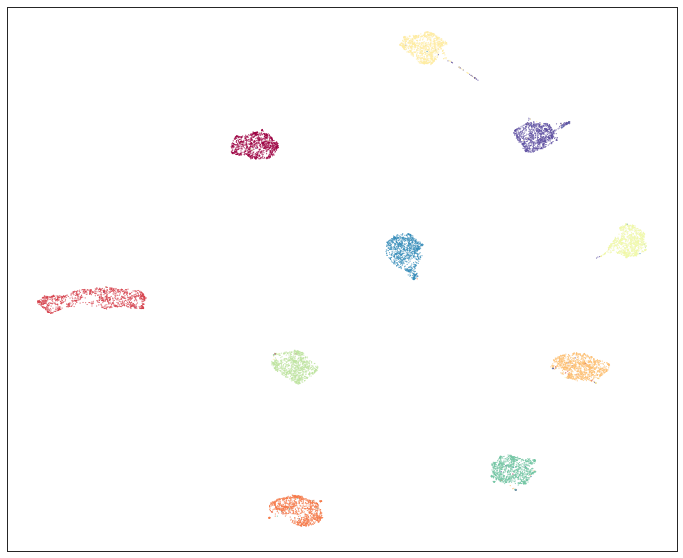

In [ ]:
import umap.umap_ as umap
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(z)

fig, ax = plt.subplots(figsize=(12, 10))
color = y.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.show()

In [ ]:
# Eval.
q, _  = model.predict([x,x,x], verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(acc_fun(y, y_pred), 5)
    nmi = np.round(nmi_fun(y, y_pred), 5)
    ari = np.round(ari_fun(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.98640, nmi = 0.96247, ari = 0.97017  ; loss= [0.03515 0.20676 0.01447]


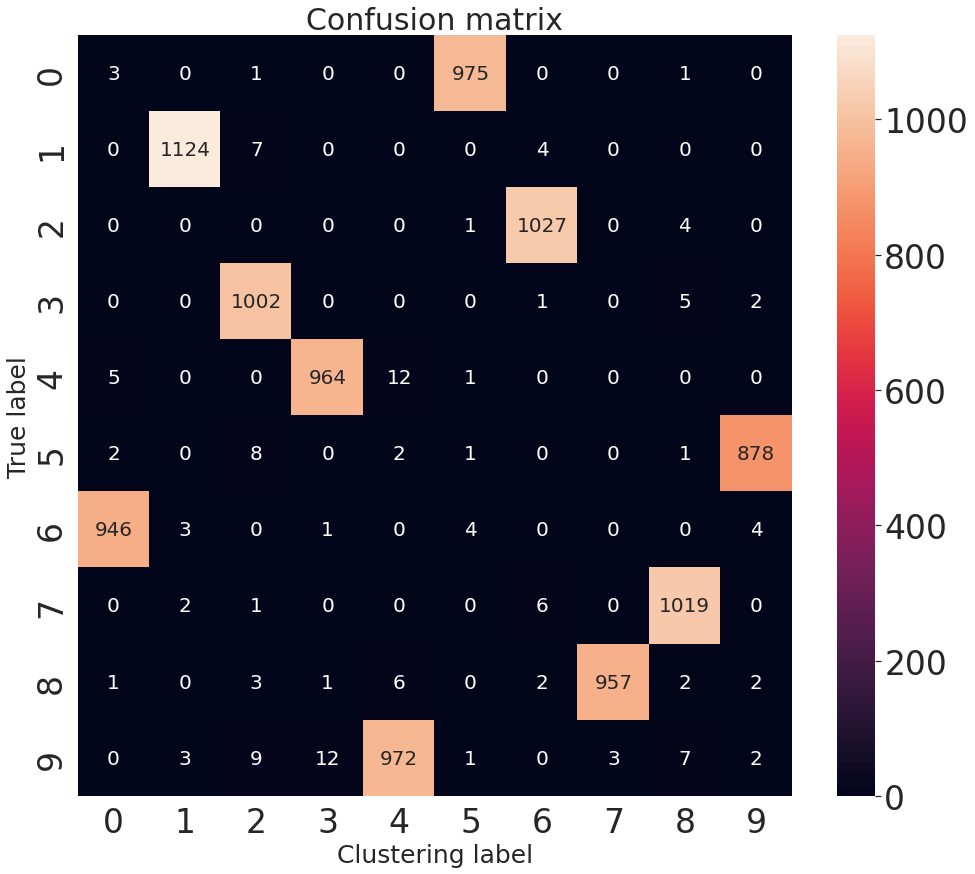

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

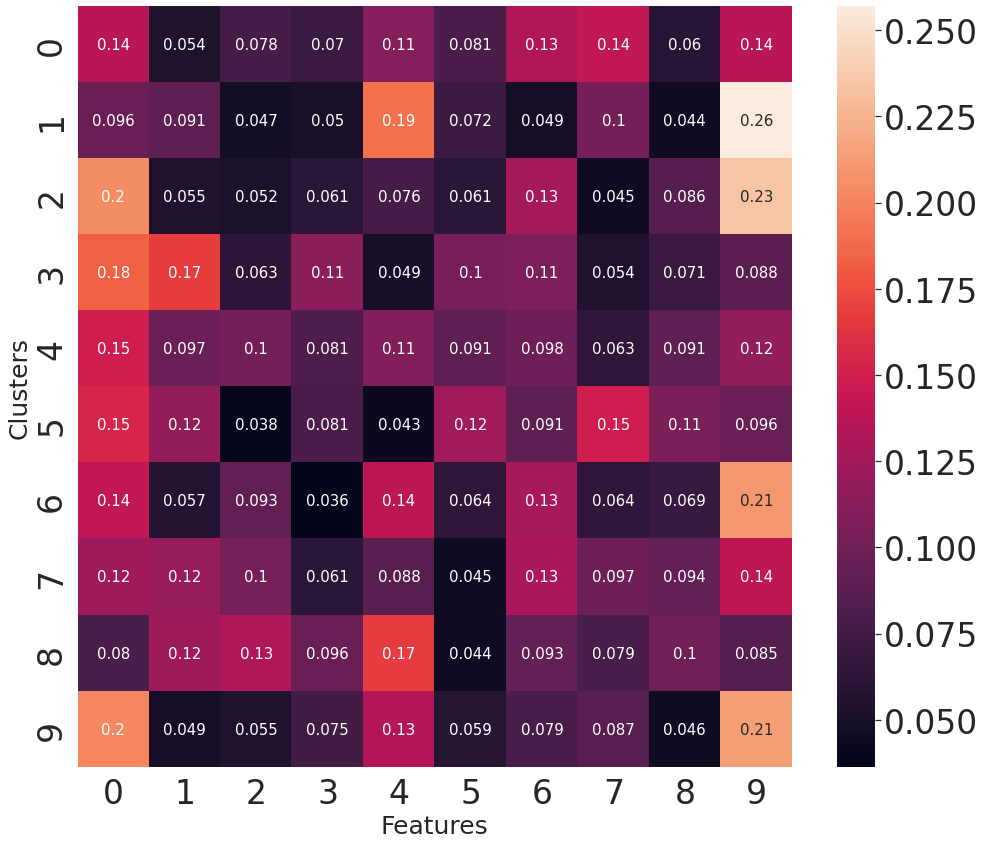

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(FeatureWeight, annot=True, annot_kws={"size": 15});
# plt.title("Feature Weight", fontsize=30)
plt.ylabel('Clusters', fontsize=25)
plt.xlabel('Features', fontsize=25)
plt.show()